In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-08 20:22:06.516550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label)) 
    ## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X)
    X=X/255.
    return X, Y

In [3]:
dir_path = '/kaggle/input/squirrel-monkey/Saimiri sciureus/'
IMG_SIZE = 150
labels = [str(i) for i in range(44)]

X, Y = make_dataset(labels, dir_path)

100%|██████████| 4/4 [00:00<00:00, 141.69it/s]


In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2021)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 2021)

# VGG 16 classification model

In [5]:
def build_model_vgg16(hp):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(units=44, activation='softmax')
])

    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics=['acc']) 
    return model

In [6]:
import keras_tuner as kt

imsize = 150
EPOCHS = 20
batch_size = 256

tuner_vgg16 = kt.RandomSearch(
    build_model_vgg16,
    objective = 'val_acc', 
    max_trials=5
)

2021-10-08 20:22:16.000093: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 20:22:16.003883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-08 20:22:16.045167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 20:22:16.045822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-08 20:22:16.045899: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 20:22:16.072894: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
tuner_vgg16.search(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Trial 4 Complete [00h 00m 10s]
val_acc: 0.6538461446762085

Best val_acc So Far: 0.7692307829856873
Total elapsed time: 00h 00m 56s


In [8]:
best_hp = tuner_vgg16.get_best_hyperparameters()[0]
model_vgg16 = tuner_vgg16.hypermodel.build(best_hp)

In [9]:
x_trainset = np.append(x_train, x_val, axis=0)
y_trainset = np.append(y_train, y_val, axis=0)

In [10]:
model_vgg16.fit(x_trainset, y_trainset,
                epochs=EPOCHS,
                batch_size=batch_size,
                verbose=1)

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 3.9685 - acc: 0.0220
Epoch 2/20
1/1 [==============================] - 0s 222ms/step - loss: 46.3541 - acc: 0.1586
Epoch 3/20
1/1 [==============================] - 0s 235ms/step - loss: 57.3769 - acc: 0.1542
Epoch 4/20
1/1 [==============================] - 0s 218ms/step - loss: 57.6617 - acc: 0.1630
Epoch 5/20
1/1 [==============================] - 0s 236ms/step - loss: 59.3257 - acc: 0.1454
Epoch 6/20
1/1 [==============================] - 0s 236ms/step - loss: 60.5839 - acc: 0.1674
Epoch 7/20
1/1 [==============================] - 0s 235ms/step - loss: 59.7430 - acc: 0.0661
Epoch 8/20
1/1 [==============================] - 0s 237ms/step - loss: 51.1844 - acc: 0.1498
Epoch 9/20
1/1 [==============================] - 0s 246ms/step - loss: 42.8694 - acc: 0.2070
Epoch 10/20
1/1 [==============================] - 0s 233ms/step - loss: 34.1611 - acc: 0.2115
Epoch 11/20
1/1 [==============================] - 0s 271ms/ste

In [11]:
model_vgg16.evaluate(x_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 1.9559 - acc: 0.5600


[1.9558966159820557, 0.5600000023841858]

# Contrastive loss

In [12]:
embeddingDim = 128

def build_model_cl(hp):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])),
        loss=tfa.losses.ContrastiveLoss())
    
    return model

In [13]:
import keras_tuner as kt

imsize = 150
EPOCHS = 20
batch_size = 256

tuner_cl = kt.RandomSearch(
    build_model_cl,
    objective = 'val_acc', 
    max_trials=5
)

In [14]:
tuner_cl.search(x_train, y_train, 
                epochs=EPOCHS, 
                validation_data=(x_val, y_val))

In [15]:
best_hp = tuner_cl.get_best_hyperparameters()[0]
model_cl = tuner_cl.hypermodel.build(best_hp)

In [16]:
model_cl.fit(x_train, y_train,
             batch_size = batch_size, 
             epochs=EPOCHS, 
             verbose=1)

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: -18.3479
Epoch 2/20
1/1 [==============================] - 0s 191ms/step - loss: -21.5408
Epoch 3/20
1/1 [==============================] - 0s 208ms/step - loss: -21.5752
Epoch 4/20
1/1 [==============================] - 0s 209ms/step - loss: -21.5739
Epoch 5/20
1/1 [==============================] - 0s 192ms/step - loss: -21.5712
Epoch 6/20
1/1 [==============================] - 0s 194ms/step - loss: -21.5705
Epoch 7/20
1/1 [==============================] - 0s 209ms/step - loss: -21.5712
Epoch 8/20
1/1 [==============================] - 0s 208ms/step - loss: -21.5723
Epoch 9/20
1/1 [==============================] - 0s 207ms/step - loss: -21.5736
Epoch 10/20
1/1 [==============================] - 0s 206ms/step - loss: -21.5747
Epoch 11/20
1/1 [==============================] - 0s 207ms/step - loss: -21.5756
Epoch 12/20
1/1 [==============================] - 0s 194ms/step - loss: -21.5763
Epoch 13/20
1/1 [===========

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def acc_cl(x_test, y_test, k = 1):
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl(x_test)
    acc_close = round(knn_cl.score(x_test_embedding, y_test), 2)
    print('The accuracy on the Closed Dataset with contrastive loss is {}'.format(acc_close))
    
    return acc_close

# Tuning k value of kNN

In [18]:
K = [1, 3, 5, 7, 9]
acc_c = []
for i in K:
    acc_c.append(acc_cl(x_val, y_val, k = i))

The accuracy on the Closed Dataset with contrastive loss is 0.5
The accuracy on the Closed Dataset with contrastive loss is 0.38
The accuracy on the Closed Dataset with contrastive loss is 0.42
The accuracy on the Closed Dataset with contrastive loss is 0.38
The accuracy on the Closed Dataset with contrastive loss is 0.38


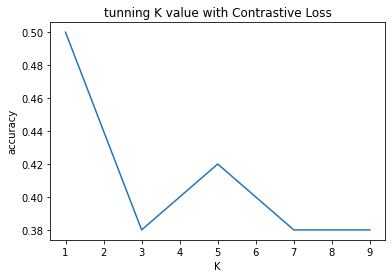

In [19]:
import matplotlib.pyplot as plt

plt.plot(K, acc_c)
plt.xlabel('K')
plt.ylabel('accuracy')
plt.title('tunning K value with Contrastive Loss')
plt.show()

In [20]:
model_cl = tuner_cl.hypermodel.build(best_hp)
model_cl.fit(x_trainset, y_trainset,
             epochs=EPOCHS,
             batch_size=batch_size,
             verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 750ms/step - loss: -18.4561
Epoch 2/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6485
Epoch 3/20
1/1 [==============================] - 0s 212ms/step - loss: -21.6804
Epoch 4/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6764
Epoch 5/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6733
Epoch 6/20
1/1 [==============================] - 0s 262ms/step - loss: -21.6732
Epoch 7/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6747
Epoch 8/20
1/1 [==============================] - 0s 218ms/step - loss: -21.6766
Epoch 9/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6784
Epoch 10/20
1/1 [==============================] - 0s 236ms/step - loss: -21.6797
Epoch 11/20
1/1 [==============================] - 0s 213ms/step - loss: -21.6806
Epoch 12/20
1/1 [==============================] - 0s 237ms/step - loss: -21.6812
Epoch 13/20
1/1 [========

In [21]:
acc_cl(x_test, y_test, k = 1)

The accuracy on the Closed Dataset with contrastive loss is 0.6


0.6

# Triplet loss

In [22]:
def build_model_tl(hp):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])),
        loss=tfa.losses.TripletSemiHardLoss())
    
    return model

In [23]:
import keras_tuner as kt

imsize = 150
EPOCHS = 20
batch_size = 256
embeddingDim = 128

tuner_tl = kt.RandomSearch(
    build_model_tl,
    objective = 'val_loss', 
    max_trials=1
)

In [24]:
tuner_tl.search(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

In [25]:
best_hp = tuner_tl.get_best_hyperparameters()[0]

In [26]:
model_tl = tuner_tl.hypermodel.build(best_hp)
model_tl.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=batch_size,
             verbose=1)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.9777
Epoch 2/20
1/1 [==============================] - 0s 201ms/step - loss: 0.9760
Epoch 3/20
1/1 [==============================] - 0s 193ms/step - loss: 0.9743
Epoch 4/20
1/1 [==============================] - 0s 192ms/step - loss: 0.9726
Epoch 5/20
1/1 [==============================] - 0s 211ms/step - loss: 0.9707
Epoch 6/20
1/1 [==============================] - 0s 199ms/step - loss: 0.9687
Epoch 7/20
1/1 [==============================] - 0s 210ms/step - loss: 0.9666
Epoch 8/20
1/1 [==============================] - 0s 211ms/step - loss: 0.9643
Epoch 9/20
1/1 [==============================] - 0s 189ms/step - loss: 0.9616
Epoch 10/20
1/1 [==============================] - 0s 212ms/step - loss: 0.9588
Epoch 11/20
1/1 [==============================] - 0s 205ms/step - loss: 0.9559
Epoch 12/20
1/1 [==============================] - 0s 209ms/step - loss: 0.9534
Epoch 13/20
1/1 [==============================] - 0

In [27]:
def acc_tl(x_test, y_test, k = 1):
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl(x_test)
    acc_close = round(knn_tl.score(x_test_embedding, y_test), 2)
    print('The accuracy on the Closed Dataset with triplet loss is {}'.format(acc_close))
    
    return acc_close

# tuning k value of kNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

K = [1, 3, 5, 7, 9]
acc_t = []
for i in K:
    acc_t.append(acc_tl(x_val, y_val, k = i))

The accuracy on the Closed Dataset with triplet loss is 0.58
The accuracy on the Closed Dataset with triplet loss is 0.46
The accuracy on the Closed Dataset with triplet loss is 0.5
The accuracy on the Closed Dataset with triplet loss is 0.42
The accuracy on the Closed Dataset with triplet loss is 0.5


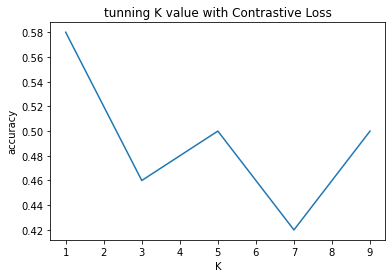

In [29]:
import matplotlib.pyplot as plt

plt.plot(K, acc_t)
plt.xlabel('K')
plt.ylabel('accuracy')
plt.title('tunning K value with Contrastive Loss')
plt.show()

In [30]:
model_tl = tuner_tl.hypermodel.build(best_hp)
model_tl.fit(x_trainset, y_trainset,
             epochs=EPOCHS,
             batch_size=batch_size,
             verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 800ms/step - loss: 0.9823
Epoch 2/20
1/1 [==============================] - 0s 216ms/step - loss: 0.9809
Epoch 3/20
1/1 [==============================] - 0s 223ms/step - loss: 0.9794
Epoch 4/20
1/1 [==============================] - 0s 224ms/step - loss: 0.9779
Epoch 5/20
1/1 [==============================] - 0s 221ms/step - loss: 0.9763
Epoch 6/20
1/1 [==============================] - 0s 240ms/step - loss: 0.9747
Epoch 7/20
1/1 [==============================] - 0s 240ms/step - loss: 0.9729
Epoch 8/20
1/1 [==============================] - 0s 228ms/step - loss: 0.9709
Epoch 9/20
1/1 [==============================] - 0s 235ms/step - loss: 0.9689
Epoch 10/20
1/1 [==============================] - 0s 239ms/step - loss: 0.9667
Epoch 11/20
1/1 [==============================] - 0s 216ms/step - loss: 0.9647
Epoch 12/20
1/1 [==============================] - 0s 223ms/step - loss: 0.9622
Epoch 13/20
1/1 [==============================] 

In [31]:
acc_tl(x_test, y_test, k = 1)

The accuracy on the Closed Dataset with triplet loss is 0.76


0.76